In [1]:
# Standard code libraries
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# Custom code libraries from the ReSurfEMG
import resurfemg.preprocessing.envelope as evl

%matplotlib widget

In [2]:
# Define signal
fs_emg = 2048
t_emg = np.array([s_t/fs_emg for s_t in range(10*fs_emg)])
# x_sin = np.sin(t_emg * 2 * np.pi)
# x_sin[x_sin < 0] = 0
std = 2
x_rand = np.random.normal(0, 1, size=len(t_emg))
x_t = np.sqrt(std) * x_rand

In [3]:
# Get RMS signal
window_s = fs_emg // 5  # 200 ms --> Delay of 100 ms
x_rms = evl.full_rolling_rms(x_t, window_s)
x_arv = evl.full_rolling_arv(x_t, window_s)

In [4]:
alpha = 0.05
window_length = window_s
rms_dist = stats.chi2.pdf([i/100 + 1 for i in range(101)], df=window_length)

In [5]:
rms_dist

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Text(0, 0.5, 'Frequency')

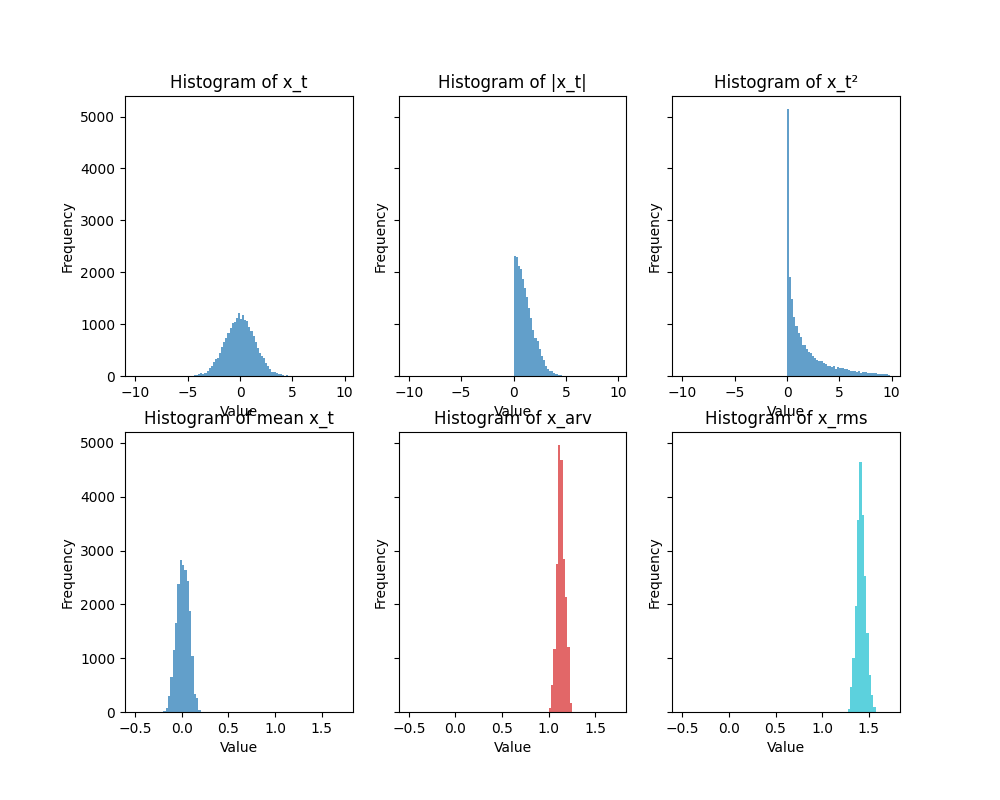

In [6]:
# Plot histograms
fig_hist, axes_hist = plt.subplots(nrows=2, ncols=3, figsize=(10, 8), sharey='row', sharex='row', )
bins = [i/5 - 10 for i in range(100)]
axes_hist[0, 0].hist(x_t, bins=bins, color='tab:blue', alpha=0.7)
axes_hist[0, 0].set_title('Histogram of x_t')
axes_hist[0, 0].set_xlabel('Value')
axes_hist[0, 0].set_ylabel('Frequency')

axes_hist[0, 1].hist(np.abs(x_t), bins=bins, color='tab:blue', alpha=0.7)
axes_hist[0, 1].set_title('Histogram of |x_t|')
axes_hist[0, 1].set_xlabel('Value')
axes_hist[0, 1].set_ylabel('Frequency')

axes_hist[0, 2].hist(x_t**2, bins=bins, color='tab:blue', alpha=0.7)
axes_hist[0, 2].set_title('Histogram of x_t²')
axes_hist[0, 2].set_xlabel('Value')
axes_hist[0, 2].set_ylabel('Frequency')

bins = [i/40 - 0.5 for i in range(90)]
axes_hist[1, 0].hist(pd.Series(x_t).rolling(window=window_s,min_periods=1).mean(), bins=bins, color='tab:blue', alpha=0.7)
axes_hist[1, 0].set_title('Histogram of mean x_t')
axes_hist[1, 0].set_xlabel('Value')
axes_hist[1, 0].set_ylabel('Frequency')


axes_hist[1, 1].hist(x_arv, bins=bins, color='tab:red', alpha=0.7)
axes_hist[1, 1].set_title('Histogram of x_arv')
axes_hist[1, 1].set_xlabel('Value')
axes_hist[1, 1].set_ylabel('Frequency')

axes_hist[1, 2].hist(x_rms, bins=bins, color='tab:cyan', alpha=0.7)
axes_hist[1, 2].set_title('Histogram of x_rms')
axes_hist[1, 2].set_xlabel('Value')
axes_hist[1, 2].set_ylabel('Frequency')

In [12]:


def rolling_rms_ci(emg_clean, window_length, alpha=0.05):
    """
    This function estimates the confidence interval for each window.
    https://stats.stackexchange.com/questions/78079/confidence-interval-of-rmse
    ---------------------------------------------------------------------------
    :param emg_clean: Samples from the EMG
    :type emg_clean: ~numpy.ndarray[float]
    :param window_length: Length of the sample used as window for function
    :type window_length: int
    :param alpha: Significance level for the confidence interval
    :type alpha: float

    :returns lower_ci: Lower bound of the confidence interval
    :rtype lower_ci: ~numpy.ndarray[float]
    :returns upper_ci: Upper bound of the confidence interval
    :rtype upper_ci: ~numpy.ndarray[float]
    """
    emg_clean_sqr = pd.Series(np.power(emg_clean, 2))
    emg_ms = emg_clean_sqr.rolling(
        window=window_length, min_periods=1, center=True).mean().values
    emg_sem = emg_clean_sqr.rolling(
        window=window_length, min_periods=1, center=True).std().values / \
            np.sqrt(window_length)
    # Calculate the confidence interval
    confidence_level = 1 - alpha
    df = window_length - 1
    ci = stats.t.interval(
        confidence_level, df, emg_ms, emg_sem)

    lower_ci = np.sqrt(ci[0])
    upper_ci = np.sqrt(ci[1])

    return lower_ci, upper_ci

In [14]:


def rolling_arv_ci(emg_clean, window_length, alpha=0.05):
    """
    This function estimates the confidence interval for each window.
    https://stats.stackexchange.com/questions/78079/confidence-interval-of-rmse
    ---------------------------------------------------------------------------
    :param emg_clean: Samples from the EMG
    :type emg_clean: ~numpy.ndarray[float]
    :param window_length: Length of the sample used as window for function
    :type window_length: int
    :param alpha: Significance level for the confidence interval
    :type alpha: float

    :returns lower_ci: Lower bound of the confidence interval
    :rtype lower_ci: ~numpy.ndarray[float]
    :returns upper_ci: Upper bound of the confidence interval
    :rtype upper_ci: ~numpy.ndarray[float]
    """
    emg_clean_abs = pd.Series(np.abs(emg_clean))
    emg_arv = emg_clean_abs.rolling(
        window=window_length, min_periods=1, center=True).mean().values
    emg_sem = pd.Series(emg_clean).rolling(
        window=window_length, min_periods=1, center=True).std().values \
            / np.sqrt(window_length)

    # Calculate the confidence interval
    confidence_level = 1 - alpha
    df = window_length - 1
    ci = stats.t.interval(
        confidence_level, df, emg_arv, emg_sem)

    lower_ci = ci[0]
    upper_ci = ci[1]

    return lower_ci, upper_ci

In [15]:
rms_lower_ci, rms_spper_ci = rolling_rms_ci(x_t, window_s)
arv_lower_ci, arv_upper_ci = rolling_arv_ci(x_t, window_s)


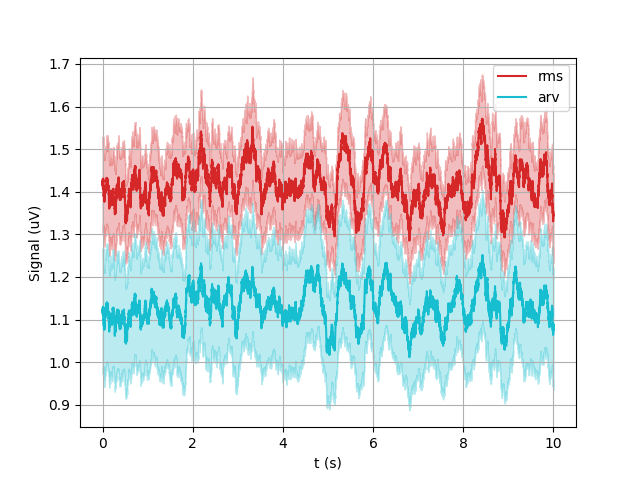

In [16]:
# Plot the raw data
signals = ['raw', 'rms', 'arv']
fig, axis = plt.subplots(nrows=1, ncols=1)
axis.grid(True)
# axis.plot(t_emg, x_t, color='tab:blue')
axis.plot(t_emg, x_rms, color='tab:red')
axis.fill_between(t_emg, rms_lower_ci, rms_spper_ci, color='tab:red', alpha=0.3)
axis.plot(t_emg, x_arv, color='tab:cyan')
axis.fill_between(t_emg, arv_lower_ci, arv_upper_ci, color='tab:cyan', alpha=0.3)
axis.set_xlabel('t (s)')
axis.set_ylabel('Signal (uV)')
axis.legend(axis.lines[:], signals[-len(axis.lines[:]):], loc='upper right')

In [21]:
from scipy.stats import bootstrap

# Define the number of bootstrap samples
n_resamples = 1000

# Define the confidence level
confidence_level = 0.95

# -- RMS Confidence Interval
# Generate bootstrap samples and compute confidence intervals
bootstrap_ci = bootstrap((x_t,), np.std, confidence_level=confidence_level,
                         n_resamples=n_resamples, method='percentile')
# Extract the lower and upper confidence intervals
bootstrap_lower_ci = bootstrap_ci.confidence_interval.low
bootstrap_upper_ci = bootstrap_ci.confidence_interval.high

emg_clean_sqr = np.power(x_t, 2)
emg_ms = np.mean(emg_clean_sqr)

# # # Calculate the confidence interval using the chi-squared distribution
# c1, c2 = stats.chi2.ppf([alpha/2,1-alpha/2], len(x_t))
# rms_lower_ci = (len(x_t) - 1) * emg_rms / c2
# rms_upper_ci = (len(x_t) - 1) * emg_rms / c1

# Calculate the confidence intervals using the t-distribution
rms_lower_ci, rms_upper_ci = rolling_rms_ci(x_t, len(x_t), alpha=alpha) 
rms_lower_ci = rms_lower_ci[len(rms_lower_ci)//2]
rms_upper_ci = rms_upper_ci[len(rms_upper_ci)//2]

print(f"Bootstrap Confidence Interval: [{bootstrap_lower_ci}, {bootstrap_upper_ci}]")
print(f"Rolling RMS Confidence Interval: [{rms_lower_ci}, {rms_upper_ci}]")


# -- ARV Confidence Interval
# Generate bootstrap samples and compute confidence intervals
bootstrap_ci = bootstrap(
    (np.abs(x_t),), np.mean, confidence_level=confidence_level,
    n_resamples=n_resamples, method='percentile')
# Extract the lower and upper confidence intervals
bootstrap_lower_ci = bootstrap_ci.confidence_interval.low
bootstrap_upper_ci = bootstrap_ci.confidence_interval.high

# emg_clean_abs = pd.Series(np.abs(x_t))
# emg_arv = np.mean(emg_clean_abs)
# emg_sem = np.std(emg_clean_abs) / np.sqrt(len(x_t))

# # Calculate the confidence interval
# confidence_level = 1 - alpha
# df = window_length - 1
# ci = stats.t.interval(
#     confidence_level, df, emg_arv, emg_sem)

# arv_lower_ci = ci[0]
# arv_upper_ci = ci[1]

arv_lower_ci, arv_upper_ci = rolling_arv_ci(x_t, len(x_t), alpha=alpha)
arv_lower_ci = arv_lower_ci[len(arv_lower_ci)//2]
arv_upper_ci = arv_upper_ci[len(arv_upper_ci)//2]


print(f"Bootstrap Confidence Interval: [{bootstrap_lower_ci}, {bootstrap_upper_ci}]")
print(f"Rolling ARV Confidence Interval: [{arv_lower_ci}, {arv_upper_ci}]")


Bootstrap Confidence Interval: [1.4063835356019894, 1.4324937035060343]
Rolling RMS Confidence Interval: [1.4058924020795942, 1.433330833393086]
Bootstrap Confidence Interval: [1.120092183573902, 1.142810879933904]
Rolling ARV Confidence Interval: [1.112202710081601, 1.1510918563545123]


In [40]:
c1_a, c2_a = stats.chi2.ppf([alpha/2,1-alpha/2], len(x_t))
c1_b, c2_b = stats.chi2.ppf([alpha/2,1-alpha/2], window_length)
c1_a, c2_a, c1_b, c2_b,  (c1_a < c2_a), (c1_b < c2_b)

(np.float64(20085.22887053258),
 np.float64(20878.55971462603),
 np.float64(354.8613245745768),
 np.float64(466.9259528311471),
 np.True_,
 np.True_)